Dataset size after cleaning: 12868 records.

Last 5 rows of features (TMIN and TMAX targets excluded from this view):
            DAY_OF_YEAR  Elevation  Humidity  Latitude   Longitude  MONTH  \
Date                                                                        
2014-07-27          208          1  0.783307  -11.0841  142.188004      7   
2014-07-28          209          1  0.768778  -11.0841  142.188004      7   
2014-07-29          210          1  0.774392  -11.0841  142.188004      7   
2014-07-30          211          1  0.751937  -11.0841  142.188004      7   
2014-07-31          212          1  0.756435  -11.0841  142.188004      7   

                PRCP  PRCP_LAG1      Solar      Wind  
Date                                                  
2014-07-27  1.453972   0.051498   9.885823  9.011771  
2014-07-28  0.175095   1.453972  12.207088  7.151790  
2014-07-29  0.199127   0.175095  12.285095  7.633007  
2014-07-30  0.260925   0.199127  15.678037  7.939729  
2014-07-31  

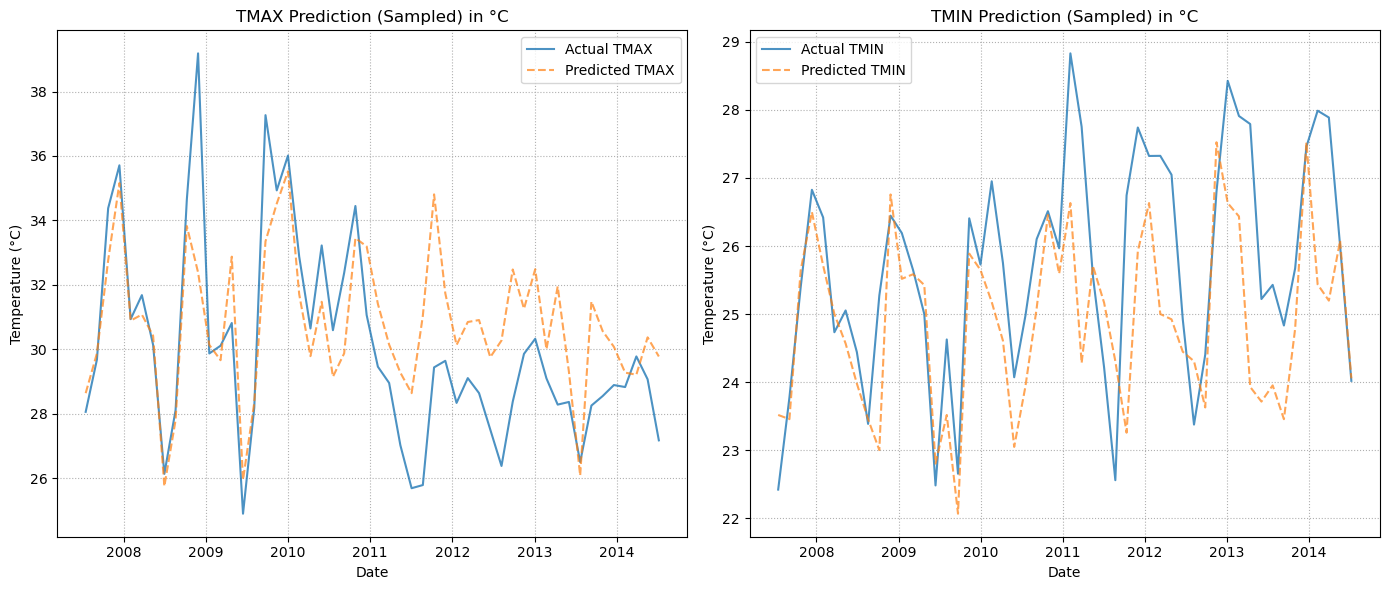

In [5]:

## Loading the dataset


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report
import warnings

# Suppress runtime warnings for cleaner output
warnings.filterwarnings('ignore')


try:
    data = pd.read_csv('/Users/dani-myburgh/Downloads/weatherdata_raw (1).csv')
except FileNotFoundError:
    print("Error: 'weatherdata_raw (1).csv' not found. Please ensure the file is in the correct path.")
    raise

# Rename columns for consistency
data.columns = [
    'Date', 'Longitude', 'Latitude', 'Elevation', 'TMAX',
    'TMIN', 'PRCP', 'Wind', 'Humidity', 'Solar'
]

# Convert 'Date' column to datetime objects and set as index
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')



# Data Cleaning and Preparation

#Handle missing values using the last known good value (forward fill).


# Handle Missing Values (Forward Fill)
data = data.ffill()

# Drop any remaining NaNs
data = data.dropna()

print(f"Dataset size after cleaning: {len(data)} records.")


#Feature Engineering: Temporal, Geographical, and Lagged Variables

#We create features required for the Multi-Output Model. The model will predict TMAX and TMIN for day $t$ using data from day $t-1$ and $t$.

#Features used:
#1. Temporal:MONTH, DAY_OF_YEAR
#2. Geographical/Fixed:Longitude, Latitude, Elevation
#3. Current/Prior Day Conditions:PRCP, Wind, Humidity, Solar (Assuming these are recorded near the time of prediction, making them current features).
#4. Lagged (T-1):Previous day's PRCP. (We cannot lag TMIN or TMAX because they are the targets we are predicting for the current day).


# 1. Temporal Features
data['MONTH'] = data.index.month
data['DAY_OF_YEAR'] = data.index.dayofyear

# 2. Lagged Meteorological Features (t-1 prediction)
# Lagged PRCP is useful as rain often spans across days.
data['PRCP_LAG1'] = data['PRCP'].shift(1)

# Drop the first row which now contains NaNs due to the shift operation
data = data.dropna()

print("\nLast 5 rows of features (TMIN and TMAX targets excluded from this view):")
print(data[data.columns.difference(['TMAX', 'TMIN'])].tail())



#Target Definition and Splitting

#Multi-Output Target:
#The target is now a 2D array/DataFrame containing both 'TMAX' and 'TMIN'.


# 1. Define Features (X)
FEATURE_COLUMNS = [
    'MONTH', 'DAY_OF_YEAR', 'Longitude', 'Latitude', 'Elevation',
    'PRCP', 'Wind', 'Humidity', 'Solar', 'PRCP_LAG1'
]
X = data[FEATURE_COLUMNS]

# 2. Define Targets (Y) - Multi-Output for Regression
TARGET_COLUMNS = ['TMAX', 'TMIN']
Y_MULTI = data[TARGET_COLUMNS]

# 3. Define Single Target (Y) - For TMAX Classification/Confusion Matrix
Y_TMAX_CLASSIFICATION = data['TMAX']

# Chronological split (80/20)
split_point = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_point], X.iloc[split_point:]

# Dual Targets for Regression
Y_train_multi, Y_test_multi = Y_MULTI.iloc[:split_point], Y_MULTI.iloc[split_point:]

# Single Target for Classification
Y_train_cls, Y_test_cls = Y_TMAX_CLASSIFICATION.iloc[:split_point], Y_TMAX_CLASSIFICATION.iloc[split_point:]

print(f"\nTrain Set Size: {len(X_train)} days")
print(f"Test Set Size: {len(X_test)} days")



#Multi-Output Regression Model (Decision Tree Regressor)

#We use the MultiOutputRegressor wrapper to allow the Decision Tree to predict both temperatures simultaneously.

print("\n" + "="*70)
print("V. Multi-Output Regression: Predicting TMAX and TMIN in °C")
print("="*70)

# Initialize the base Decision Tree Regressor
base_dtr = DecisionTreeRegressor(max_depth=12, random_state=42)

# Wrap the DTR in a MultiOutputRegressor
multi_target_dtr = MultiOutputRegressor(base_dtr)

# Train the model
multi_target_dtr.fit(X_train, Y_train_multi)

# Make predictions (returns a 2D array: [TMAX_pred, TMIN_pred])
Y_pred_multi = multi_target_dtr.predict(X_test)

# Convert predictions back to a DataFrame for easy evaluation
Y_pred_df = pd.DataFrame(Y_pred_multi, index=Y_test_multi.index, columns=TARGET_COLUMNS)

print("Decision Tree Multi-Output Regressor Performance on Test Set:")

# Evaluate and print metrics for TMAX
mae_max = mean_absolute_error(Y_test_multi['TMAX'], Y_pred_df['TMAX'])
rmse_max = np.sqrt(mean_squared_error(Y_test_multi['TMAX'], Y_pred_df['TMAX']))
print(f" - TMAX MAE: {mae_max:.2f} °C | RMSE: {rmse_max:.2f} °C")

# Evaluate and print metrics for TMIN
mae_min = mean_absolute_error(Y_test_multi['TMIN'], Y_pred_df['TMIN'])
rmse_min = np.sqrt(mean_squared_error(Y_test_multi['TMIN'], Y_pred_df['TMIN']))
print(f" - TMIN MAE: {mae_min:.2f} °C | RMSE: {rmse_min:.2f} °C")

# Plotting Dual Regression Results
plt.figure(figsize=(14, 6))

# Plot TMAX
plt.subplot(1, 2, 1)
plt.plot(Y_test_multi.index[::50], Y_test_multi['TMAX'].values[::50], label='Actual TMAX', alpha=0.8)
plt.plot(Y_pred_df.index[::50], Y_pred_df['TMAX'].values[::50], label='Predicted TMAX', alpha=0.7, linestyle='--')
plt.title('TMAX Prediction (Sampled) in °C')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, linestyle=':')

# Plot TMIN
plt.subplot(1, 2, 2)
plt.plot(Y_test_multi.index[::50], Y_test_multi['TMIN'].values[::50], label='Actual TMIN', alpha=0.8)
plt.plot(Y_pred_df.index[::50], Y_pred_df['TMIN'].values[::50], label='Predicted TMIN', alpha=0.7, linestyle='--')
plt.title('TMIN Prediction (Sampled) in °C')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True, linestyle=':')

plt.tight_layout()
plt.show()